In [89]:
import argparse
import logging
import pprint
import os
import sys
from itertools import chain
from collections import Counter

import torch
import torch.utils.data
import torch.nn.functional as F
import transformers
import datasets
import wandb

from tqdm import tqdm
import matplotlib.pyplot as plt

import class_attention as cat

# Prepare and train a model

In [28]:
class args:
    dataset = "../data/news-category-semantic-split-small"
    model = "distilbert-base-uncased"
    test_class_frac = 0.0
    dataset_frac = 1.0
    batch_size = 32
    device = "cuda:1"
    lr = 1e-4
    max_epochs = 5
    normailze_cls = True
    normalize_txt = True
    scale_attention = False
    freeze_cls_network = False
    learn_temperature = True
    use_n_projection_layers = None


In [12]:
(
    train_dataloader,
    test_dataloader,
    all_classes_str,
    test_classes_str,
) = cat.training_utils.prepare_dataloaders(
    dataset_name_or_path=args.dataset,
    model_name=args.model,
    test_class_frac=args.test_class_frac,
    dataset_frac=args.dataset_frac,
    batch_size=args.batch_size,
)


In [29]:
text_encoder = transformers.AutoModel.from_pretrained(args.model)
label_encoder = transformers.AutoModel.from_pretrained(args.model)

model = cat.ClassAttentionModel(
    text_encoder,
    label_encoder,
    **vars(args),
)
model = model.to(args.device)

In [ ]:
parameters = model.get_trainable_parameters()
optimizer = torch.optim.Adam(parameters, lr=args.lr)

config = {k: v for k, v in vars(args).items() if not k.startswith("_")}

wandb.init(project="class_attention", config=config, tags=["notebook"])
wandb.watch(model, log="all")

In [31]:
model = cat.training_utils.train_cat_model(
    model,
    optimizer,
    train_dataloader,
    test_dataloader,
    all_classes_str,
    test_classes_str,
    args.max_epochs,
    args.device,
)

# Error analysis

In [16]:
text_tokenizer = test_dataloader.dataset.text_tokenizer
label_tokenizer = test_dataloader.dataset.label_tokenizer

_t, _c = test_dataloader.dataset[4]
text_tokenizer.decode(_t), label_tokenizer.decode(_c)

("[CLS] behind closed doors, donald trump's adviser explains his real economic plan [SEP]",
 '[CLS] politics [SEP]')

In [17]:
set(all_classes_str).difference(test_classes_str)

{'ARTS',
 'ARTS & CULTURE',
 'BLACK VOICES',
 'BUSINESS',
 'COLLEGE',
 'COMEDY',
 'CRIME',
 'ENTERTAINMENT',
 'ENVIRONMENT',
 'FIFTY',
 'FOOD & DRINK',
 'GOOD NEWS',
 'GREEN',
 'HEALTHY LIVING',
 'HOME & LIVING',
 'IMPACT',
 'MEDIA',
 'MONEY',
 'PARENTING',
 'POLITICS',
 'QUEER VOICES',
 'RELIGION',
 'SCIENCE',
 'SPORTS',
 'STYLE & BEAUTY',
 'TASTE',
 'TECH',
 'THE WORLDPOST',
 'TRAVEL',
 'WEDDINGS',
 'WEIRD NEWS',
 'WELLNESS',
 'WOMEN'}

In [18]:
test_classes_str

['DIVORCE',
 'CULTURE & ARTS',
 'WORLDPOST',
 'STYLE',
 'LATINO VOICES',
 'PARENTS',
 'WORLD NEWS',
 'EDUCATION']

In [22]:
news_dataset = datasets.load_from_disk("../data/news-category-semantic-split-small")
_, only_test_classes_data = cat.utils.split_classes(news_dataset["validation"], test_classes=test_classes_str)

otc_dataset = cat.CatDataset(
    only_test_classes_data["headline"],
    text_tokenizer,
    only_test_classes_data["category"],
    label_tokenizer,
)

test_classes_ids = label_tokenizer.batch_encode_plus(
    test_classes_str,
    return_tensors="pt",
    add_special_tokens=True,
    padding=True,
)["input_ids"]

otc_collator = cat.CatTestCollator(
    possible_labels_ids=test_classes_ids, pad_token_id=label_tokenizer.pad_token_id
)

otc_dataloader = torch.utils.data.DataLoader(otc_dataset, collate_fn=otc_collator, shuffle=False, pin_memory=True)

In [55]:
metrics = cat.utils.evaluate_model_per_class(
    model,
    otc_dataloader,
    device=args.device,
    labels_str=test_classes_str,
    zeroshot_labels=test_classes_str,
)

metrics

2021-02-23 17:40:37 | WARNING | utils.py | No classes for the group multi_shot
2021-02-23 17:40:37 | WARNING | utils.py | No classes for the group multi_shot
2021-02-23 17:40:37 | WARNING | utils.py | No classes for the group multi_shot


{'acc': tensor(0.5055, device='cuda:1'),
 'P/DIVORCE': 0.8333333287037037,
 'R/DIVORCE': 0.6521739102079395,
 'F1/DIVORCE': 0.731707264247475,
 'P/CULTURE & ARTS': 0.0,
 'R/CULTURE & ARTS': 0.0,
 'F1/CULTURE & ARTS': 0.0,
 'P/WORLDPOST': 0.42857142653061225,
 'R/WORLDPOST': 0.5999999960000001,
 'F1/WORLDPOST': 0.4999999486111158,
 'P/STYLE': 0.9999999666666678,
 'R/STYLE': 0.3749999953125001,
 'F1/STYLE': 0.5454544958677713,
 'P/LATINO VOICES': 0.42857142244897967,
 'R/LATINO VOICES': 0.5999999880000002,
 'F1/LATINO VOICES': 0.4999999430555604,
 'P/PARENTS': 0.7222222182098765,
 'R/PARENTS': 0.6842105227146814,
 'F1/PARENTS': 0.7027026489408363,
 'P/WORLD NEWS': 0.14285714081632656,
 'R/WORLD NEWS': 0.07142857091836735,
 'F1/WORLD NEWS': 0.09523804988664196,
 'P/EDUCATION': 0.22222221975308645,
 'R/EDUCATION': 0.6666666444444452,
 'F1/EDUCATION': 0.3333332902777817,
 'R_zero_shot': 0.45618495344974175,
 'P_zero_shot': 0.47222221539115655,
 'F1_zero_shot': 0.4260544551108978}

In [24]:
random_model = cat.ClassAttentionModel(
    transformers.AutoModel.from_config(transformers.AutoConfig.from_pretrained(args.model)),
    transformers.AutoModel.from_config(transformers.AutoConfig.from_pretrained(args.model)),
)

metrics_random = cat.utils.evaluate_model_per_class(
    random_model,
    otc_dataloader,
    device=args.device,
    labels_str=test_classes_str,
    zeroshot_labels=test_classes_str,
)

metrics_random

2021-02-23 17:25:46 | WARNING | utils.py | No classes for the group multi_shot
2021-02-23 17:25:46 | WARNING | utils.py | No classes for the group multi_shot
2021-02-23 17:25:46 | WARNING | utils.py | No classes for the group multi_shot


{'acc': tensor(0.0549, device='cuda:1'),
 'P/DIVORCE': 0.0,
 'R/DIVORCE': 0.0,
 'F1/DIVORCE': 0.0,
 'P/CULTURE & ARTS': 0.0,
 'R/CULTURE & ARTS': 0.0,
 'F1/CULTURE & ARTS': 0.0,
 'P/WORLDPOST': 0.0,
 'R/WORLDPOST': 0.0,
 'F1/WORLDPOST': 0.0,
 'P/STYLE': 0.0,
 'R/STYLE': 0.0,
 'F1/STYLE': 0.0,
 'P/LATINO VOICES': 0.0,
 'R/LATINO VOICES': 0.0,
 'F1/LATINO VOICES': 0.0,
 'P/PARENTS': 0.14285714217687073,
 'R/PARENTS': 0.15789473601108034,
 'F1/PARENTS': 0.14999994937501657,
 'P/WORLD NEWS': 0.0,
 'R/WORLD NEWS': 0.0,
 'F1/WORLD NEWS': 0.0,
 'P/EDUCATION': 0.028571428530612248,
 'R/EDUCATION': 0.6666666444444452,
 'F1/EDUCATION': 0.05479451251642051,
 'R_zero_shot': 0.1030701725569407,
 'P_zero_shot': 0.021428571338435374,
 'F1_zero_shot': 0.025599307736429634}

In [25]:
bert_model = cat.ClassAttentionModel(
    transformers.AutoModel.from_pretrained(args.model),
    transformers.AutoModel.from_pretrained(args.model),
)

metrics_bert = cat.utils.evaluate_model_per_class(
    bert_model,
    otc_dataloader,
    device=args.device,
    labels_str=test_classes_str,
    zeroshot_labels=test_classes_str,
)

metrics_bert

2021-02-23 17:25:49 | WARNING | utils.py | No classes for the group multi_shot
2021-02-23 17:25:49 | WARNING | utils.py | No classes for the group multi_shot
2021-02-23 17:25:49 | WARNING | utils.py | No classes for the group multi_shot


{'acc': tensor(0.0440, device='cuda:1'),
 'P/DIVORCE': 0.0,
 'R/DIVORCE': 0.0,
 'F1/DIVORCE': 0.0,
 'P/CULTURE & ARTS': 0.04395604390774061,
 'R/CULTURE & ARTS': 0.9999999750000006,
 'F1/CULTURE & ARTS': 0.08421051807202275,
 'P/WORLDPOST': 0.0,
 'R/WORLDPOST': 0.0,
 'F1/WORLDPOST': 0.0,
 'P/STYLE': 0.0,
 'R/STYLE': 0.0,
 'F1/STYLE': 0.0,
 'P/LATINO VOICES': 0.0,
 'R/LATINO VOICES': 0.0,
 'F1/LATINO VOICES': 0.0,
 'P/PARENTS': 0.0,
 'R/PARENTS': 0.0,
 'F1/PARENTS': 0.0,
 'P/WORLD NEWS': 0.0,
 'R/WORLD NEWS': 0.0,
 'F1/WORLD NEWS': 0.0,
 'P/EDUCATION': 0.0,
 'R/EDUCATION': 0.0,
 'F1/EDUCATION': 0.0,
 'R_zero_shot': 0.12499999687500007,
 'P_zero_shot': 0.0054945054884675765,
 'F1_zero_shot': 0.010526314759002843}

In [26]:
class_counts = Counter(otc_dataloader.dataset.labels)
class_counts

Counter({'WORLDPOST': 15,
         'PARENTS': 19,
         'WORLD NEWS': 14,
         'DIVORCE': 23,
         'STYLE': 8,
         'EDUCATION': 3,
         'LATINO VOICES': 5,
         'CULTURE & ARTS': 4})

In [27]:
{k: v / len(otc_dataloader.dataset) for k, v in class_counts.most_common()}

{'DIVORCE': 0.25274725274725274,
 'PARENTS': 0.2087912087912088,
 'WORLDPOST': 0.16483516483516483,
 'WORLD NEWS': 0.15384615384615385,
 'STYLE': 0.08791208791208792,
 'LATINO VOICES': 0.054945054945054944,
 'CULTURE & ARTS': 0.04395604395604396,
 'EDUCATION': 0.03296703296703297}

## Result

For the semantic split, trained class attention model, **when evaluated on zero-shot classes only**, is significantly better than a random baseline or a constant baseline

* Random accuracy: 0.06
* BERT without fine-tuning: 0.04
* Best constant accuracy: 0.25

* Model (CLS network fixed): 0.34
* Model (CLS network fine-tuned): 0.50

In [43]:
set(all_classes_str).difference(set(test_classes_str))

{'ARTS',
 'ARTS & CULTURE',
 'BLACK VOICES',
 'BUSINESS',
 'COLLEGE',
 'COMEDY',
 'CRIME',
 'ENTERTAINMENT',
 'ENVIRONMENT',
 'FIFTY',
 'FOOD & DRINK',
 'GOOD NEWS',
 'GREEN',
 'HEALTHY LIVING',
 'HOME & LIVING',
 'IMPACT',
 'MEDIA',
 'MONEY',
 'PARENTING',
 'POLITICS',
 'QUEER VOICES',
 'RELIGION',
 'SCIENCE',
 'SPORTS',
 'STYLE & BEAUTY',
 'TASTE',
 'TECH',
 'THE WORLDPOST',
 'TRAVEL',
 'WEDDINGS',
 'WEIRD NEWS',
 'WELLNESS',
 'WOMEN'}

In [79]:
_all_classes_str = test_classes_str + [
#  'ARTS',
#  'ARTS & CULTURE',
#  'BLACK VOICES',
#  'BUSINESS',
#  'COLLEGE',
#  'COMEDY',
#  'CRIME',
#  'ENTERTAINMENT',
#  'ENVIRONMENT',
#  'FIFTY',
#  'FOOD & DRINK',
#  'GOOD NEWS',
#  'GREEN',
#  'HEALTHY LIVING',
#  'HOME & LIVING',
#  'IMPACT',
#  'MEDIA',
#  'MONEY',
#  'PARENTING',
#  'POLITICS',
#  'QUEER VOICES',
#  'RELIGION',
#  'SCIENCE',
#  'SPORTS',
#  'STYLE & BEAUTY',
#  'TASTE',
#  'TECH',
#  'THE WORLDPOST',
#  'TRAVEL',
#  'WEDDINGS',
#  'WEIRD NEWS',
#  'WELLNESS',
#  'WOMEN',
]

all_classes_ids = label_tokenizer.batch_encode_plus(
    _all_classes_str,
    return_tensors="pt",
    add_special_tokens=True,
    padding=True,
)["input_ids"]

all_classes_collator = cat.CatTestCollator(
    possible_labels_ids=all_classes_ids, pad_token_id=label_tokenizer.pad_token_id
)

otc_dataloader_all_classes = torch.utils.data.DataLoader(otc_dataset, collate_fn=all_classes_collator, shuffle=False, pin_memory=True)

In [80]:
cat.utils.evaluate_model_per_class(
    model,
    otc_dataloader_all_classes,
    device=args.device,
    labels_str=_all_classes_str,
    zeroshot_labels=test_classes_str,
)

2021-02-23 17:45:00 | WARNING | utils.py | No classes for the group multi_shot
2021-02-23 17:45:00 | WARNING | utils.py | No classes for the group multi_shot
2021-02-23 17:45:00 | WARNING | utils.py | No classes for the group multi_shot


{'acc': tensor(0.5055, device='cuda:1'),
 'P/DIVORCE': 0.8333333287037037,
 'R/DIVORCE': 0.6521739102079395,
 'F1/DIVORCE': 0.731707264247475,
 'P/CULTURE & ARTS': 0.0,
 'R/CULTURE & ARTS': 0.0,
 'F1/CULTURE & ARTS': 0.0,
 'P/WORLDPOST': 0.42857142653061225,
 'R/WORLDPOST': 0.5999999960000001,
 'F1/WORLDPOST': 0.4999999486111158,
 'P/STYLE': 0.9999999666666678,
 'R/STYLE': 0.3749999953125001,
 'F1/STYLE': 0.5454544958677713,
 'P/LATINO VOICES': 0.42857142244897967,
 'R/LATINO VOICES': 0.5999999880000002,
 'F1/LATINO VOICES': 0.4999999430555604,
 'P/PARENTS': 0.7222222182098765,
 'R/PARENTS': 0.6842105227146814,
 'F1/PARENTS': 0.7027026489408363,
 'P/WORLD NEWS': 0.14285714081632656,
 'R/WORLD NEWS': 0.07142857091836735,
 'F1/WORLD NEWS': 0.09523804988664196,
 'P/EDUCATION': 0.22222221975308645,
 'R/EDUCATION': 0.6666666444444452,
 'F1/EDUCATION': 0.3333332902777817,
 'R_zero_shot': 0.45618495344974175,
 'P_zero_shot': 0.47222221539115655,
 'F1_zero_shot': 0.4260544551108978}

In [84]:
0.3 - metrics['acc'].item()

-0.20549453496932985

In [85]:
class2delta = dict()

for extra_class in set(all_classes_str).difference(set(test_classes_str)):
    _all_classes_str = test_classes_str + [extra_class]
    
    all_classes_ids = label_tokenizer.batch_encode_plus(
    _all_classes_str,
    return_tensors="pt",
    add_special_tokens=True,
    padding=True,
    )["input_ids"]

    all_classes_collator = cat.CatTestCollator(
        possible_labels_ids=all_classes_ids, pad_token_id=label_tokenizer.pad_token_id
    )

    otc_dataloader_all_classes = torch.utils.data.DataLoader(otc_dataset, collate_fn=all_classes_collator, shuffle=False, pin_memory=True)
    
    metrics = cat.utils.evaluate_model_per_class(
        model,
        otc_dataloader_all_classes,
        device=args.device,
        labels_str=_all_classes_str,
        zeroshot_labels=test_classes_str,
    )
    
    class2delta[extra_class] = metrics["acc"].item() - 0.5055

class2delta

{'HOME & LIVING': -0.010994505167007396,
 'TECH': -5.4650306701153895e-06,
 'MEDIA': -0.054950546503066966,
 'COMEDY': -0.04396153616905207,
 'BUSINESS': -0.021983515501022288,
 'WEIRD NEWS': -0.010994505167007396,
 'SPORTS': -5.4650306701153895e-06,
 'PARENTING': -0.08791757750511164,
 'ENVIRONMENT': -0.010994505167007396,
 'RELIGION': -0.03297252583503718,
 'FIFTY': -0.021983515501022288,
 'GREEN': -0.021983515501022288,
 'STYLE & BEAUTY': -0.021983515501022288,
 'POLITICS': -0.08791757750511164,
 'TASTE': -0.010994505167007396,
 'ARTS': -5.4650306701153895e-06,
 'HEALTHY LIVING': -0.03297252583503718,
 'SCIENCE': -5.4650306701153895e-06,
 'ENTERTAINMENT': -0.04396153616905207,
 'ARTS & CULTURE': -5.4650306701153895e-06,
 'IMPACT': -0.021983515501022288,
 'GOOD NEWS': -0.010994505167007396,
 'QUEER VOICES': -5.4650306701153895e-06,
 'COLLEGE': -0.010994505167007396,
 'WOMEN': -0.04396153616905207,
 'THE WORLDPOST': -0.08791757750511164,
 'WELLNESS': -0.04396153616905207,
 'WEDDINGS':

<BarContainer object of 33 artists>

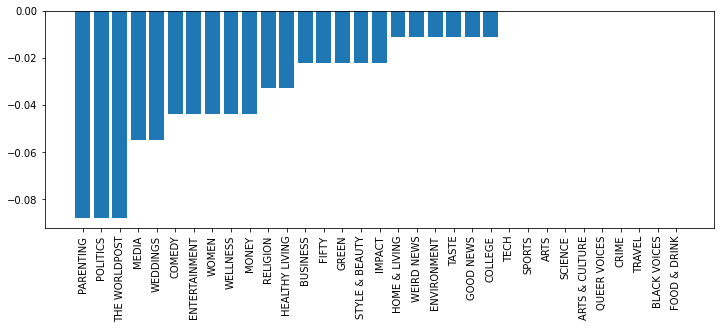

In [100]:
items = sorted(class2delta.items(), key=lambda x: x[1])

plt.figure(figsize=(12, 4))
plt.xticks(rotation=90)
counts = Counter(news_dataset['train']['category'])
plt.bar(*zip(*items))

In [102]:
all_classes_ids = label_tokenizer.batch_encode_plus(
    all_classes_str,
    return_tensors="pt",
    add_special_tokens=True,
    padding=True,
)["input_ids"]

all_classes_ids.shape

torch.Size([41, 5])

In [129]:
model_out = model.cls_encoder(input_ids=all_classes_ids.to(args.device))
class_embeddings = model_out.last_hidden_state[:, 0, :]
class_embeddings = cat.modelling_utils.normalize_embeds(class_embeddings)
class_embeddings = class_embeddings.detach().cpu().numpy()
class_embeddings.shape

(41, 768)

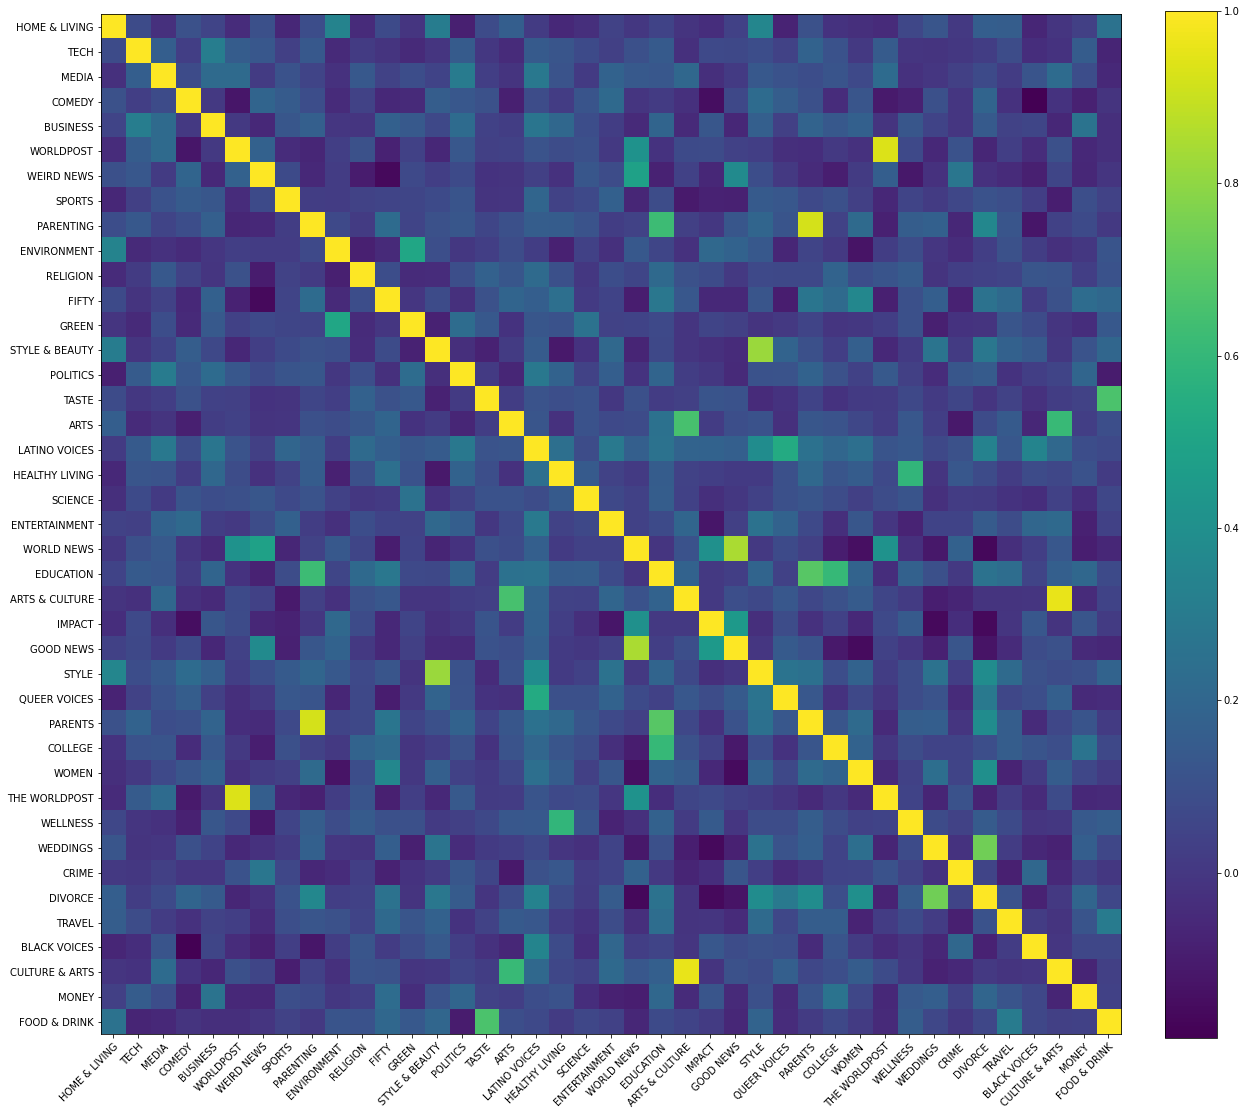

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

ax.set_xticks(range(len(all_classes_str)))
ax.set_yticks(range(len(all_classes_str)))
ax.set_xticklabels(all_classes_str)
ax.set_yticklabels(all_classes_str)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
im = ax.imshow(class_embeddings @ class_embeddings.T)
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)